In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install pycocoevalcap
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.spice.spice import Spice

import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras_preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [ ]:
image_path = "/content/drive/Shareddrives/DLSD/Images/"
dir_Flickr_text = "/content/drive/Shareddrives/DLSD/Flickr8k.token.txt"
path_npy = "/content/drive/Shareddrives/DLSD/Numpy/"
jpgs = os.listdir(path_npy)

# print("Total Images in Dataset = {}".format(len(jpgs)))

In [ ]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

imgnames = []
for im in jpgs:
  a = im.split('.')
  imgnames.append(a[0]+'.'+a[1])

datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    if w[0] in imgnames:
      datatxt.append(w + [col[1].lower()])
data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


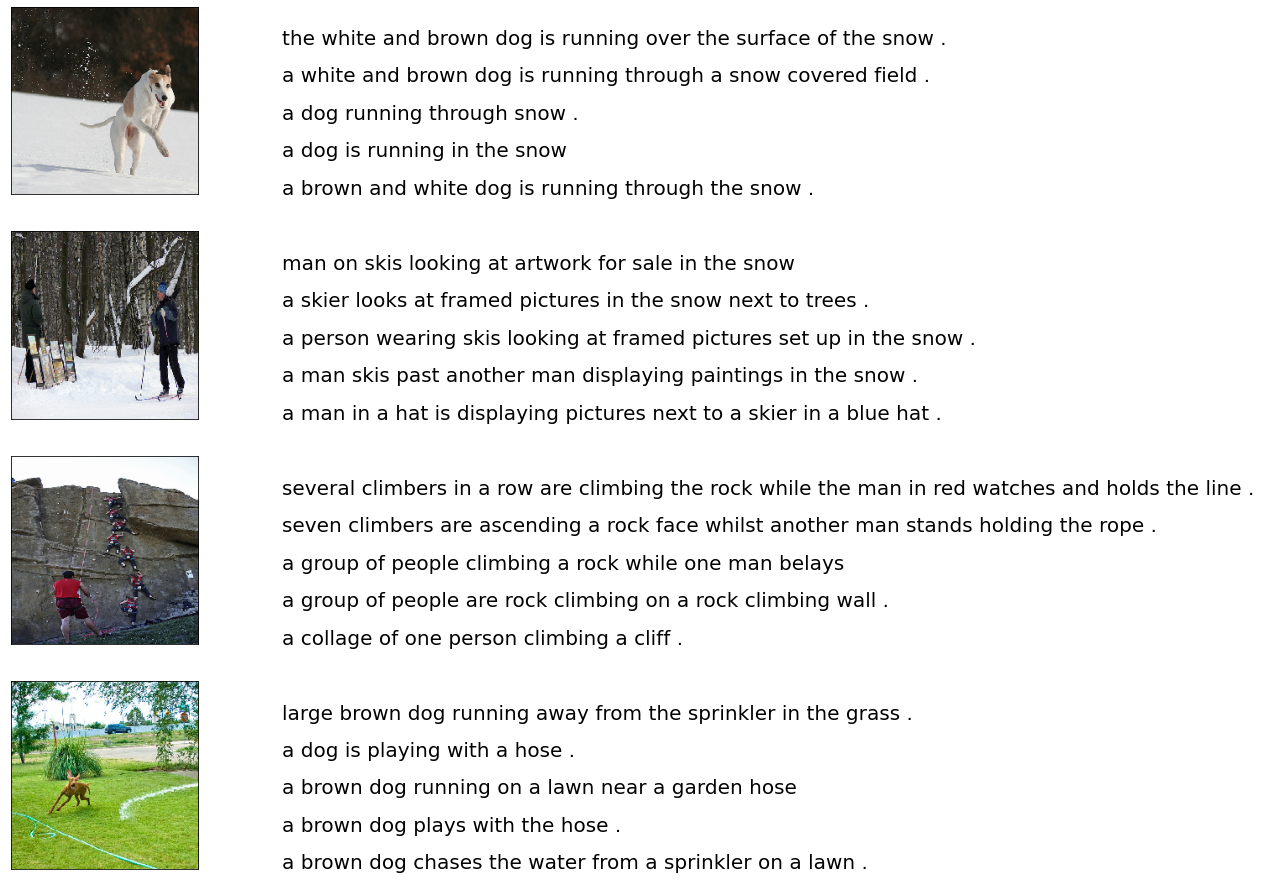

In [ ]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [ ]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8866


In [ ]:
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)

for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [ ]:
clean_vocabulary = []
for txt in data.caption.values:
    clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8307


In [ ]:
PATH = "/content/drive/Shareddrives/DLSD/Images/"

all_captions = []
for caption  in data["caption"].astype(str):
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [ ]:
all_img_name_vector = []
for annot in data["filename"]:
    full_image_path = PATH + annot
    all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/content/drive/Shareddrives/DLSD/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/Shareddrives/DLSD/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/Shareddrives/DLSD/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/Shareddrives/DLSD/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/Shareddrives/DLSD/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/Shareddrives/DLSD/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/Shareddrives/DLSD/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/Shareddrives/DLSD/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/Shareddrives/DLSD/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/Shareddrives/DLSD/Images/1001773457_577c3a7d70.jpg']

In [ ]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [ ]:
%%time
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        path_of_feature = path_of_feature.replace("Images", "Numpy" )
        # print(path_of_feature)
        np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [04:08<00:00,  1.96s/it]

CPU times: user 1min 35s, sys: 5.96 s, total: 1min 41s
Wall time: 4min 8s


In [ ]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
train_captions[:3]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>']

In [ ]:
train_seqs[:3]

[[2, 184, 62, 331, 64, 524, 12, 329, 6, 5, 167, 3],
 [2, 11, 588, 4, 5, 2384, 895, 5, 93, 1281, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 280, 3]]

In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
    return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


In [ ]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [ ]:
print(len(img_name_val))
print(len(img_name_train))

8000
32000


In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [ ]:
def map_func(img_name, cap):
    txt = img_name.decode('utf-8')+'.npy'
    arr = txt.split('/')
    # print(arr[-1])
    img_tensor = np.load(path_npy + arr[-1])
    return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
class VGG16_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(VGG16_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)
        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class LocalAttentionModel(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(LocalAttentionModel, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')

        self.fc1 = tf.keras.layers.Dense(self.units)

        self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
        self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

        self.fc2 = tf.keras.layers.Dense(vocab_size)

        # Implementing Attention Mechanism
        self.Uattn = tf.keras.layers.Dense(units)
        self.Wattn = tf.keras.layers.Dense(units)
        self.Vattn = tf.keras.layers.Dense(1)

    def call(self, x, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)

        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x= self.dropout(x)
        x= self.batchnormalization(x)
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


encoder = VGG16_Encoder(embedding_dim)
decoder = LocalAttentionModel(embedding_dim, units, vocab_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
    loss = 0

    hidden = decoder.reset_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.get_shape()[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

In [ ]:
EPOCHS = 20
start_epoch = 0
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in tqdm(enumerate(dataset)):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
            epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
            loss_plot.append(total_loss / num_steps)
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

2it [00:24, 10.30s/it]

Epoch 1 Batch 0 Loss 1.0916


102it [00:40,  7.00it/s]

Epoch 1 Batch 100 Loss 1.1194


202it [00:54,  7.22it/s]

Epoch 1 Batch 200 Loss 1.1358


302it [01:08,  6.88it/s]

Epoch 1 Batch 300 Loss 1.2330


402it [01:25,  7.60it/s]

Epoch 1 Batch 400 Loss 1.0023


500it [02:01,  4.12it/s]


Epoch 1 Loss 1.106471
Time taken for 1 epoch 121.5112509727478 sec



2it [00:01,  1.56it/s]

Epoch 2 Batch 0 Loss 0.9618


102it [00:15,  7.23it/s]

Epoch 2 Batch 100 Loss 0.9600


202it [00:28,  7.16it/s]

Epoch 2 Batch 200 Loss 1.0645


302it [00:42,  6.82it/s]

Epoch 2 Batch 300 Loss 0.9428


402it [00:56,  6.73it/s]

Epoch 2 Batch 400 Loss 0.9314


500it [01:08,  7.26it/s]


Epoch 2 Loss 0.990646
Time taken for 1 epoch 68.908132314682 sec



2it [00:01,  1.57it/s]

Epoch 3 Batch 0 Loss 0.8844


102it [00:15,  7.09it/s]

Epoch 3 Batch 100 Loss 0.8835


202it [00:29,  7.22it/s]

Epoch 3 Batch 200 Loss 0.9734


302it [00:43,  7.46it/s]

Epoch 3 Batch 300 Loss 0.9619


402it [00:57,  7.35it/s]

Epoch 3 Batch 400 Loss 0.8214


500it [01:09,  7.16it/s]


Epoch 3 Loss 0.907859
Time taken for 1 epoch 69.86169862747192 sec



2it [00:01,  1.53it/s]

Epoch 4 Batch 0 Loss 0.7733


102it [00:16,  7.06it/s]

Epoch 4 Batch 100 Loss 0.7911


202it [00:30,  7.85it/s]

Epoch 4 Batch 200 Loss 0.8185


302it [00:44,  6.72it/s]

Epoch 4 Batch 300 Loss 0.7813


402it [00:58,  7.45it/s]

Epoch 4 Batch 400 Loss 0.8323


500it [01:10,  7.05it/s]


Epoch 4 Loss 0.841407
Time taken for 1 epoch 70.97815155982971 sec



2it [00:01,  1.59it/s]

Epoch 5 Batch 0 Loss 0.8107


102it [00:15,  6.71it/s]

Epoch 5 Batch 100 Loss 0.7479


202it [00:29,  7.48it/s]

Epoch 5 Batch 200 Loss 0.8408


302it [00:42,  7.39it/s]

Epoch 5 Batch 300 Loss 0.8579


402it [00:56,  7.82it/s]

Epoch 5 Batch 400 Loss 0.7790


500it [01:09,  7.23it/s]


Epoch 5 Loss 0.784903
Time taken for 1 epoch 81.91354608535767 sec



2it [00:01,  1.58it/s]

Epoch 6 Batch 0 Loss 0.6809


102it [00:15,  6.93it/s]

Epoch 6 Batch 100 Loss 0.7502


202it [00:28,  6.99it/s]

Epoch 6 Batch 200 Loss 0.7436


302it [00:42,  7.40it/s]

Epoch 6 Batch 300 Loss 0.7765


402it [00:56,  7.46it/s]

Epoch 6 Batch 400 Loss 0.7305


500it [01:09,  7.24it/s]


Epoch 6 Loss 0.734346
Time taken for 1 epoch 69.11890983581543 sec



2it [00:01,  1.54it/s]

Epoch 7 Batch 0 Loss 0.7604


102it [00:15,  7.04it/s]

Epoch 7 Batch 100 Loss 0.6458


202it [00:30,  5.08it/s]

Epoch 7 Batch 200 Loss 0.6522


302it [00:44,  7.14it/s]

Epoch 7 Batch 300 Loss 0.6588


402it [00:58,  6.47it/s]

Epoch 7 Batch 400 Loss 0.6361


500it [01:11,  7.00it/s]


Epoch 7 Loss 0.691642
Time taken for 1 epoch 71.47741389274597 sec



2it [00:01,  1.58it/s]

Epoch 8 Batch 0 Loss 0.6268


102it [00:15,  7.06it/s]

Epoch 8 Batch 100 Loss 0.6922


202it [00:28,  7.18it/s]

Epoch 8 Batch 200 Loss 0.5648


302it [00:42,  6.82it/s]

Epoch 8 Batch 300 Loss 0.6708


402it [00:56,  7.22it/s]

Epoch 8 Batch 400 Loss 0.6783


500it [01:09,  7.19it/s]


Epoch 8 Loss 0.650322
Time taken for 1 epoch 69.5435848236084 sec



2it [00:01,  1.58it/s]

Epoch 9 Batch 0 Loss 0.5433


102it [00:15,  6.78it/s]

Epoch 9 Batch 100 Loss 0.5805


202it [00:29,  7.07it/s]

Epoch 9 Batch 200 Loss 0.6555


302it [00:43,  6.95it/s]

Epoch 9 Batch 300 Loss 0.5670


402it [00:56,  7.01it/s]

Epoch 9 Batch 400 Loss 0.5845


500it [01:09,  7.17it/s]


Epoch 9 Loss 0.615434
Time taken for 1 epoch 69.74161124229431 sec



2it [00:01,  1.63it/s]

Epoch 10 Batch 0 Loss 0.5535


102it [00:15,  7.07it/s]

Epoch 10 Batch 100 Loss 0.6036


202it [00:29,  7.51it/s]

Epoch 10 Batch 200 Loss 0.4990


302it [00:42,  7.19it/s]

Epoch 10 Batch 300 Loss 0.6147


402it [00:57,  6.21it/s]

Epoch 10 Batch 400 Loss 0.5675


500it [01:10,  7.10it/s]


Epoch 10 Loss 0.583234
Time taken for 1 epoch 70.40237593650818 sec



2it [00:01,  1.57it/s]

Epoch 11 Batch 0 Loss 0.5946


102it [00:15,  6.33it/s]

Epoch 11 Batch 100 Loss 0.6370


202it [00:29,  7.69it/s]

Epoch 11 Batch 200 Loss 0.6085


302it [00:43,  7.72it/s]

Epoch 11 Batch 300 Loss 0.5562


402it [00:56,  6.80it/s]

Epoch 11 Batch 400 Loss 0.5526


500it [01:09,  7.18it/s]


Epoch 11 Loss 0.553497
Time taken for 1 epoch 69.61431002616882 sec



2it [00:01,  1.55it/s]

Epoch 12 Batch 0 Loss 0.5504


102it [00:15,  6.62it/s]

Epoch 12 Batch 100 Loss 0.5208


202it [00:29,  6.66it/s]

Epoch 12 Batch 200 Loss 0.4846


302it [00:42,  7.86it/s]

Epoch 12 Batch 300 Loss 0.5016


402it [00:56,  6.72it/s]

Epoch 12 Batch 400 Loss 0.5524


500it [01:09,  7.22it/s]


Epoch 12 Loss 0.527867
Time taken for 1 epoch 69.2465181350708 sec



2it [00:01,  1.58it/s]

Epoch 13 Batch 0 Loss 0.5750


102it [00:15,  8.00it/s]

Epoch 13 Batch 100 Loss 0.5494


202it [00:28,  7.75it/s]

Epoch 13 Batch 200 Loss 0.5172


302it [00:42,  6.47it/s]

Epoch 13 Batch 300 Loss 0.4885


402it [00:56,  7.82it/s]

Epoch 13 Batch 400 Loss 0.5544


500it [01:09,  7.19it/s]


Epoch 13 Loss 0.504223
Time taken for 1 epoch 69.53153324127197 sec



2it [00:01,  1.62it/s]

Epoch 14 Batch 0 Loss 0.4530


102it [00:16,  7.21it/s]

Epoch 14 Batch 100 Loss 0.5684


202it [00:30,  7.14it/s]

Epoch 14 Batch 200 Loss 0.4716


302it [00:44,  7.64it/s]

Epoch 14 Batch 300 Loss 0.5002


402it [00:58,  7.27it/s]

Epoch 14 Batch 400 Loss 0.4764


500it [01:10,  7.05it/s]


Epoch 14 Loss 0.482337
Time taken for 1 epoch 70.94520664215088 sec



2it [00:01,  1.65it/s]

Epoch 15 Batch 0 Loss 0.5088


102it [00:15,  7.15it/s]

Epoch 15 Batch 100 Loss 0.4791


202it [00:28,  6.54it/s]

Epoch 15 Batch 200 Loss 0.4498


302it [00:42,  7.55it/s]

Epoch 15 Batch 300 Loss 0.4827


402it [00:56,  7.21it/s]

Epoch 15 Batch 400 Loss 0.4514


500it [01:08,  7.28it/s]


Epoch 15 Loss 0.462465
Time taken for 1 epoch 68.68048286437988 sec



2it [00:01,  1.58it/s]

Epoch 16 Batch 0 Loss 0.4773


102it [00:15,  6.82it/s]

Epoch 16 Batch 100 Loss 0.4451


202it [00:28,  6.91it/s]

Epoch 16 Batch 200 Loss 0.4177


302it [00:42,  7.23it/s]

Epoch 16 Batch 300 Loss 0.4162


402it [00:56,  7.00it/s]

Epoch 16 Batch 400 Loss 0.4440


500it [01:09,  7.21it/s]


Epoch 16 Loss 0.443218
Time taken for 1 epoch 69.33939456939697 sec



2it [00:01,  1.63it/s]

Epoch 17 Batch 0 Loss 0.4350


102it [00:15,  7.17it/s]

Epoch 17 Batch 100 Loss 0.4109


202it [00:29,  6.96it/s]

Epoch 17 Batch 200 Loss 0.4602


302it [00:43,  4.81it/s]

Epoch 17 Batch 300 Loss 0.4637


402it [00:57,  6.72it/s]

Epoch 17 Batch 400 Loss 0.3909


500it [01:10,  7.05it/s]


Epoch 17 Loss 0.427409
Time taken for 1 epoch 70.96237659454346 sec



2it [00:01,  1.57it/s]

Epoch 18 Batch 0 Loss 0.4234


102it [00:15,  7.57it/s]

Epoch 18 Batch 100 Loss 0.4134


202it [00:29,  6.88it/s]

Epoch 18 Batch 200 Loss 0.3734


302it [00:42,  7.28it/s]

Epoch 18 Batch 300 Loss 0.3747


402it [00:56,  7.00it/s]

Epoch 18 Batch 400 Loss 0.3566


500it [01:09,  7.23it/s]


Epoch 18 Loss 0.410823
Time taken for 1 epoch 69.21321845054626 sec



2it [00:01,  1.59it/s]

Epoch 19 Batch 0 Loss 0.3553


102it [00:15,  7.59it/s]

Epoch 19 Batch 100 Loss 0.4206


202it [00:29,  7.10it/s]

Epoch 19 Batch 200 Loss 0.4392


302it [00:42,  6.60it/s]

Epoch 19 Batch 300 Loss 0.3777


402it [00:56,  7.87it/s]

Epoch 19 Batch 400 Loss 0.4212


500it [01:09,  7.23it/s]


Epoch 19 Loss 0.395506
Time taken for 1 epoch 69.15751767158508 sec



2it [00:01,  1.59it/s]

Epoch 20 Batch 0 Loss 0.3783


102it [00:15,  7.40it/s]

Epoch 20 Batch 100 Loss 0.3420


202it [00:29,  7.06it/s]

Epoch 20 Batch 200 Loss 0.3932


302it [00:42,  7.08it/s]

Epoch 20 Batch 300 Loss 0.3445


402it [00:56,  7.54it/s]

Epoch 20 Batch 400 Loss 0.3534


500it [01:08,  7.26it/s]

Epoch 20 Loss 0.382379
Time taken for 1 epoch 68.89412307739258 sec



In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    features=encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)
    attention_plot = attention_plot[:len(result), :]

    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

Real Caption: the black dogs are running in grassy field
Prediction Caption: pack of black dogs running in grass


Exception ignored in: <function Meteor.__del__ at 0x7f058c136310>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pycocoevalcap/meteor/meteor.py", line 78, in __del__
    self.lock.acquire()
KeyboardInterrupt: 


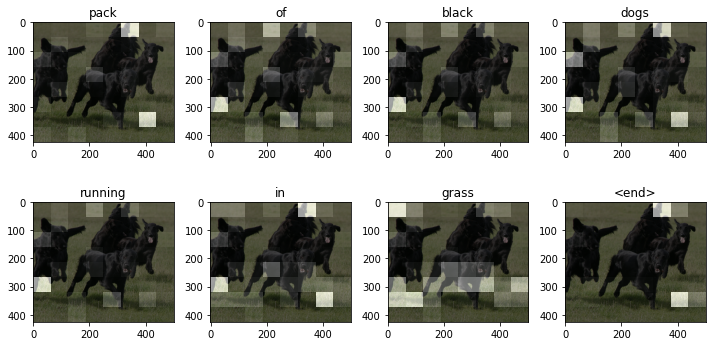

time took to Predict: 1255 sec


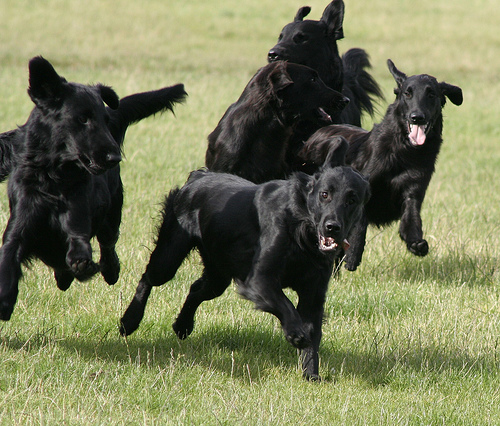

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
start = time.time()
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in result:
   if i=="<unk>":
       result.remove(i)
     
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
print(f"time took to Predict: {round(time.time()-start)} sec")

Image.open(img_name_val[rid])

BELU score: 2.697887185123482e-76
Real Caption: group of people outside having their picture taken
Prediction Caption: group of people gather for picture while woman stands on post and takes the picture


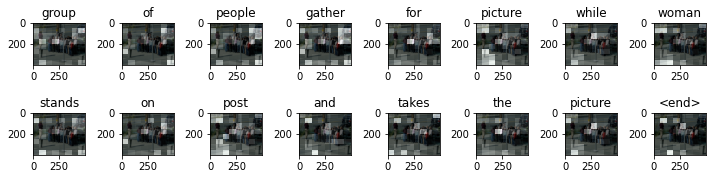

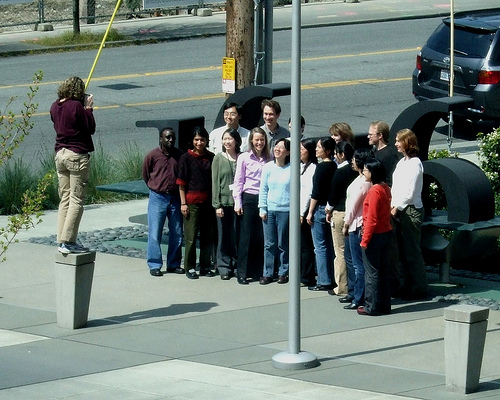

In [ ]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)     
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)

plot_attention(image, result, attention_plot)
Image.open(img_name_val[rid])

In [ ]:
#Class for metrics calclulation
class COCOEvalCap:
    def __init__(self,images,gts,res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'image_id': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['image_id']
        gts = self.gts
        res = self.res
        print('tokenization...')
        tokenizer = PTBTokenizer()
        gts  = tokenizer.tokenize(gts)
        res = tokenizer.tokenize(res)
        print('setting up scorers...')
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr"),
            (Spice(), "SPICE")
        ]

        # =================================================
        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print('computing %s score...'%(scorer.method()))
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

In [ ]:
imgIds = []
gts = {}
res = {}

image_test = set(img_name_val)
image_test = list(image_test)
print(image_test)
for key in tqdm(image_test[0:1000]):
    X = key.split('/')
    imgIds.append(X[-1])

    captions = list(data["caption"].loc[data["filename"]==X[-1]].values)
    # y_pred = predict_caption(modelLSTM, features[key], tokenizer, max_length)
    result, _ = evaluate(key)
    
    for i in result:
        if i=="<unk>":
            result.remove(i)
      
    result_join = ' '.join(result)
    result_final = result_join.rsplit(' ', 1)[0]

    gts[X[-1]] = [{'image_id': X[-1], 'caption': caption} for caption in captions]
    res[X[-1]] = [{'image_id': X[-1], 'caption': result_final}]
    
evalObj = COCOEvalCap(imgIds,gts,res)
evalObj.evaluate()

print(evalObj.eval)


['/content/drive/Shareddrives/DLSD/Images/3649307685_60c1294d2a.jpg', '/content/drive/Shareddrives/DLSD/Images/509241560_00e5b20562.jpg', '/content/drive/Shareddrives/DLSD/Images/2774430374_fee1d793e7.jpg', '/content/drive/Shareddrives/DLSD/Images/1163282319_b729b24c46.jpg', '/content/drive/Shareddrives/DLSD/Images/2832978253_8fcc72da3b.jpg', '/content/drive/Shareddrives/DLSD/Images/632608471_a70461f123.jpg', '/content/drive/Shareddrives/DLSD/Images/427167162_2c99779444.jpg', '/content/drive/Shareddrives/DLSD/Images/3654869593_c8599a8e20.jpg', '/content/drive/Shareddrives/DLSD/Images/3681324243_b69fa90842.jpg', '/content/drive/Shareddrives/DLSD/Images/97105139_fae46fe8ef.jpg', '/content/drive/Shareddrives/DLSD/Images/1962729184_6996e128e7.jpg', '/content/drive/Shareddrives/DLSD/Images/390992102_67fa31b22f.jpg', '/content/drive/Shareddrives/DLSD/Images/3523819210_99782628fc.jpg', '/content/drive/Shareddrives/DLSD/Images/2743709828_a795a75bfc.jpg', '/content/drive/Shareddrives/DLSD/Image

100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


tokenization...
setting up scorers...
computing Bleu score...
{'testlen': 10373, 'reflen': 8320, 'guess': [10373, 9373, 8373, 7377], 'correct': [5929, 3704, 2222, 1313]}
ratio: 1.2467548076921577
Bleu_1: 0.572
Bleu_2: 0.475
Bleu_3: 0.391
Bleu_4: 0.321
computing METEOR score...
METEOR: 0.284
computing Rouge score...
ROUGE_L: 0.559
computing CIDEr score...
CIDEr: 1.099
computing SPICE score...
SPICE: 0.229
{'Bleu_1': 0.5715800636266681, 'Bleu_2': 0.47526377877180614, 'Bleu_3': 0.39136092840354797, 'Bleu_4': 0.32138776159606974, 'METEOR': 0.28354373274539224, 'ROUGE_L': 0.5589794382766838, 'CIDEr': 1.0993774330651782, 'SPICE': 0.22916900995914827}
